# Summary - Gather Process Trees

### Part I

1. From the ```process_uber_summary``` table, build an ```igraph``` directed graph $G$ where each edge is of the form: ```parent PID --> child PID```
2. Enrich $G$ with metadata for each PID (process name, timestamp, mitre labels, etc.)
3. Get all (weak) connected components from $G$ -- those are the ```process trees``` (with one exception where a loop is present), and save those in the **Trees** object
4. Provide some basic visualization and EDA for the process trees

### Part II

Most process trees are of size 2, and a few are huge.
For every process tree of size 3 to 10,0000, consider every rooted subtree of size 3 or more that has a process name for ther root and gather the following statistics:

1. The tree and root node indices in the **Trees** object
2. Number of nodes, leaves, tree depth, number of nodes at each level, list of process names at each level
3. Number of splits (forks of size 2 or more) and ratio of splits to nodes (this can be used to filter broom-like trees, for example)
4. Number of processes from a *baduser*
5. Save the above in dataframe **process_df**

We will use the subtrees in **process_df** to test various mathematical models.


# Introduction

The first few cells are taken from BH's ```process-name-curation``` notebook


In [1]:
%load_ext autoreload
%load_ext dotenv
#%load_ext quak 
%load_ext sql

Tip: You may define configurations in /work/home/fcthebe/Acme4/Forked/Wintap-Analytics/2025-acme4-explore/pyproject.toml or /work/home/fcthebe/.jupysql/config.

Did not find user configurations in /work/home/fcthebe/Acme4/Forked/Wintap-Analytics/2025-acme4-explore/pyproject.toml.

In [2]:
%autoreload 1
%aimport acme4_explore

In [3]:
%dotenv

cannot find .env file


In [4]:
%%time
import acme4_explore
import datamapplot as dmp
from fast_hdbscan import HDBSCAN
import io
import json
import logging as lg
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sentencepiece import SentencePieceTrainer, SentencePieceProcessor
from sklearn.metrics.pairwise import paired_distances
from tqdm.auto import tqdm, trange
import umap
import vectorizers as vz
import vectorizers.transformers as vzt
import zstandard as zstd

import seaborn as sns
from collections import Counter
import igraph as ig


CPU times: user 31.2 s, sys: 3.96 s, total: 35.1 s
Wall time: 31.8 s


In [5]:
# Registers the current `tqdm` class with pandas.core.
tqdm.pandas()


In [6]:
lg.basicConfig(**acme4_explore.logging_config())
LOG = lg.getLogger("notebook")


In [7]:
db = acme4_explore.connect_db()
%sql db --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True


# Part I --  Build process trees from the ```process_uber_summary``` table

We keep the relevant columns to build the process trees plus some extra information for each process.


In [8]:
%%sql process_summary <<
select * from process_uber_summary


In [9]:
cols = ['pid_hash', 
        'parent_pid_hash',
        'process_name',
        'process_path',
        'user_name',
        'mitre_analytic_ids',
        'lolbas_mitre',
        'total_sigma_hits',
        'process_started'
        
]
df = process_summary[cols]    
df = df.drop_duplicates([
        'pid_hash', 
        'parent_pid_hash',
        'process_name',
        'process_path',
        'user_name',
        'total_sigma_hits',
        'process_started'])
print('shape:',df.shape)
df.head(5)


shape: (1772947, 9)


,pid_hash,parent_pid_hash,process_name,process_path,user_name,mitre_analytic_ids,lolbas_mitre,total_sigma_hits,process_started
0,55EB90CA560661116B2960AB86A5B0C2,6DA116CF30116D13D73F0176C88FE8FA,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",2.0,2024-09-21 08:46:37.950828+00:00
1,1C0E33336B247AB3545467D0C90A801C,7BAAE96741807787EFD2D6522B8C6B04,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",2.0,2024-09-21 13:54:18.404907+00:00
2,3657145DA95C462B0F632F0A93E632E3,6FB634509A57999E72BCAFA74A8FFF29,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",3.0,2024-09-21 18:31:49.308847+00:00
3,DB85B49E03DF8060FA14B3F0B934D589,7BAAE96741807787EFD2D6522B8C6B04,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",2.0,2024-09-21 15:49:18.430852+00:00
4,2D9432D76FDFDEF205D46F0137EAFEB3,7BAAE96741807787EFD2D6522B8C6B04,wmic.exe,c:\windows\system32\wbem\wmic.exe,None,[CAR-2021-05-012],"[T1218, T1564.004]",3.0,2024-09-21 17:49:18.352182+00:00


## Build graph $G$ and find the connected components 

* directed edges are set to : parent -> child
* the connected components correspond to the process trees (with one exception which has a loop)
* main objects: ```G``` in the overall directed graph and ```Trees``` contains all process trees


### Build graph $G$

In [10]:
child = set(df.pid_hash)
parent = set(df.parent_pid_hash)
print('processes:')
print('children:',len(child),', parents:',len(parent),', both:',len(parent.intersection(child)))

## node dictionaries
nodes = parent.union(child)
nodes_dict = {v:k for k,v in enumerate(nodes)}
inv_nodes_dict = {k:v for k,v in enumerate(nodes)}

## build directed graph from edgelist
child = [nodes_dict[x] for x in df.pid_hash]
parent = [nodes_dict[x] for x in df.parent_pid_hash]
edges = np.array([parent,child]).T

## build graph
G = ig.Graph.TupleList(edges, directed=True)
G = G.simplify() ## there are 53 self-edges
print('final tree:')
print('nodes:',G.vcount(),', edges:',G.ecount())
G.vs['pid'] = [inv_nodes_dict[int(x)] for x in G.vs['name']]


processes:
children: 1772947 , parents: 1253672 , both: 142448
final tree:
nodes: 2884171 , edges: 1772894


### Save components in **Trees** object


In [11]:
## find all connected components a.k.a. process trees (with one exception)
Trees = G.connected_components(mode="weak")
G.vs['tree'] = Trees.membership
print('Number of components:',len(Trees))
## most common component sizes
print('most common sizes:')
Counter([len(x) for x in Trees]).most_common(5)


Number of components: 1111278
most common sizes:


[(2, 1111052), (3, 94), (4, 21), (5, 12), (12, 11)]

### Example

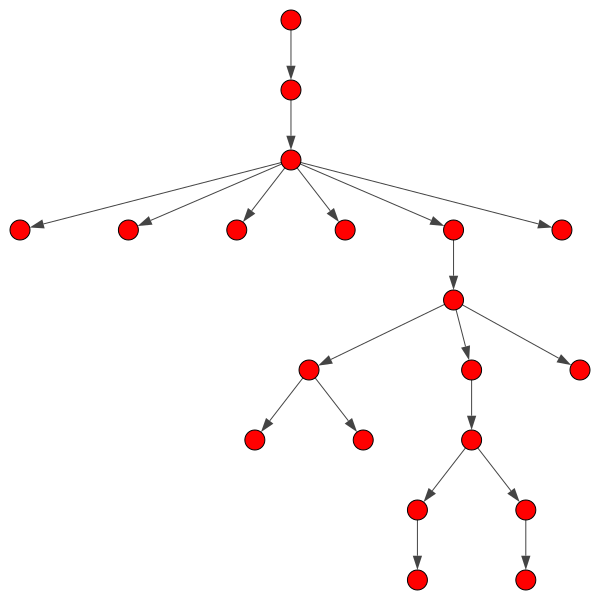

In [12]:
## ex: showing a size 20 component
idx = np.where(np.array(Trees.sizes())==20)[0][0]
sg = Trees.subgraph(idx)
ly = sg.layout_reingold_tilford()
ig.plot(sg, layout=ly)

### There are 1,111,278 components -- one component is NOT a tree


In [13]:
## count roots (no in degree)
print('number of roots:',sum(np.array(G.degree(mode='in'))==0))

## identify the non-tree component
s = set(np.array(Trees.membership)[np.where(np.array(G.degree(mode='in'))==0)[0]])
c = set(np.arange(1111278)).difference(s)
non_tree = c.pop()
sg = Trees.subgraph(non_tree)
print('\nnon-tree:\n','nodes:',sg.vcount(),'edges:',sg.ecount())
print(' acyclic:',sg.is_acyclic())
print(' index in Trees object:',non_tree)


number of roots: 1111277

non-tree:
 nodes: 22576 edges: 22576
 acyclic: False
 index in Trees object: 731680


### Adding node features

Enrich graph ```G``` with:

* username
* process name
* timestamp
* mitre and lolbas ids, sigma count


In [14]:
## usernames
user_dict = dict(zip(df.pid_hash,df.user_name))
G.vs['username'] = [user_dict.get(x, None) for x in G.vs['pid']]
Counter(G.vs['username']).most_common(10)


[(None, 2582643),
 ('NT AUTHORITY\\SYSTEM', 282540),
 ('ACME\\ghostuser2', 3956),
 ('NT AUTHORITY\\NETWORK SERVICE', 3621),
 ('ACME\\grantj', 2165),
 ('ACME\\ghostuser1', 1364),
 ('ACME\\user10', 1198),
 ('ACME\\user1', 1143),
 ('ACME\\davidf', 803),
 ('ACME\\user3', 747)]

In [15]:
## process names
process_dict = dict(zip(df.pid_hash, df.process_name))
G.vs['process'] = [process_dict.get(x, "") for x in G.vs['pid']]
# merge None and ''
x = np.where(np.array(G.vs['process'])==None)[0]
G.vs[x]['process'] = ''
Counter(G.vs['process']).most_common(10)


[('conhost.exe', 1243884),
 ('', 1118246),
 ('wmic.exe', 283125),
 ('mergehelper.exe', 122882),
 ('svchost.exe', 14979),
 ('updater.exe', 9939),
 ('taskhostw.exe', 8159),
 ('microsoftedgeupdate.exe', 7889),
 ('mousocoreworker.exe', 7219),
 ('firefox.exe', 6911)]

In [16]:
## timestamps
T = []
for x in df['process_started']:
    if pd.isna(x):
        T.append('')
    else: 
        T.append(int(x.timestamp()))
time_dict = dict(zip(  df.pid_hash, T))
G.vs['time'] = [time_dict.get(x, "") for x in G.vs['pid']]


In [17]:
## mitre, lolbas, sigma
_dict = dict(zip(df.pid_hash, df.mitre_analytic_ids))
G.vs['mitre'] = [_dict.get(x, "") for x in G.vs['pid']]
_dict = dict(zip(df.pid_hash, df.lolbas_mitre))
G.vs['lolbas'] = [_dict.get(x, "") for x in G.vs['pid']]
_dict = dict(zip(df.pid_hash, df.total_sigma_hits))
G.vs['sigma'] = [_dict.get(x, "") for x in G.vs['pid']]


### Plotting parameters

Manually set short usernames and node colours for plotting


In [18]:
## short names for plotting and anonymize
shortname_dict = {'ACME-HH-BKQ\\ssm-user':'ssmBKQ',
 'ACME-HH-WHS\\ssm-user':'ssmWHS',
 'ACME-HH-YVU\\ssm-user':'ssmYVU',
 'ACME-WS-PLU\\ssm-user':'ssmPLU',
 'ACME\\SUPERDA':'user99',
 'ACME\\baduser25':'bad25',
 'ACME\\baduser3':'bad3',
 'ACME\\baduser9':'bad9',
 'ACME\\davidf':'user77',
 'ACME\\ghostuser1':'ghost1',
 'ACME\\ghostuser2':'ghost2',
 'ACME\\grantj':'user88',
 'ACME\\user1':'user1',
 'ACME\\user10':'user10',
 'ACME\\user11':'user11',
 'ACME\\user2':'user2',
 'ACME\\user20':'user20',
 'ACME\\user3':'user3',
 'ACME\\user4':'user4',
 'ACME\\user6':'user6',
 'ACME\\user8':'user8',
 'ACME\\user9':'user9',
 'EC2AMAZ-R9HHULK\\Administrator':'admin',
 'Font Driver Host\\UMFD-0':'umfd0',
 'Font Driver Host\\UMFD-1':'umfd1',
 'Font Driver Host\\UMFD-2':'umfd2',
 'Font Driver Host\\UMFD-3':'umfd3',
 'Font Driver Host\\UMFD-4':'umfd4',
 'Font Driver Host\\UMFD-5':'umfd5',
 'Font Driver Host\\UMFD-6':'umfd6',
 'Font Driver Host\\UMFD-7':'umfd7',
 'NT AUTHORITY\\LOCAL SERVICE':'LOCAL',
 'NT AUTHORITY\\NETWORK SERVICE':'NET',
 'NT AUTHORITY\\SYSTEM':'SYS',
  None:'',
 'ROOT':'ROOT',
 'Window Manager\\DWM-1':'dwm1',
 'Window Manager\\DWM-2':'dwm2',
 'Window Manager\\DWM-3':'dwm3',
 'Window Manager\\DWM-4':'dwm4',
 'Window Manager\\DWM-5':'dwm5',
 'Window Manager\\DWM-6':'dwm6',
 'Window Manager\\DWM-7':'dwm7'}

## node labels
G.vs['label'] = [shortname_dict[v['username']]+'::'+v['process'] for v in G.vs]
G.vs['shortlabel'] = [shortname_dict[v['username']] for v in G.vs]

## use red for badusers
G.vs['label_color'] = 'black'
G.vs['color'] = 'black'
G.vs[np.where(['bad' in x for x in G.vs['shortlabel']])[0]]['label_color'] = 'red'
G.vs[np.where(['bad' in x for x in G.vs['shortlabel']])[0]]['color'] = 'red'


### Identify process trees with bad users and visualize a few

There are very few of those ...


In [19]:
## counting trees with badusers
_df = pd.DataFrame()
_df['name'] = G.vs['shortlabel']
_df['tree'] = G.vs['tree']
_df['size'] = 1
_df = pd.get_dummies(_df, columns=['name'] ) ## convert categorical to indicator variables
cols = ['tree','size','name_bad3','name_bad9','name_bad25']
_df = _df[cols]
_grouped = _df.groupby(by='tree').sum()
_grouped[ (_grouped['name_bad3']>0) | (_grouped['name_bad9']>0) | (_grouped['name_bad25']>0)]


,size,name_bad3,name_bad9,name_bad25
tree,,,,
2,28780,274,0,0
5,11735,0,0,40
722,2926,0,40,0
724,852,360,0,0
726,17894,2,0,0
733,1339,0,296,0
2014,23,8,0,0
14973,123,0,64,0


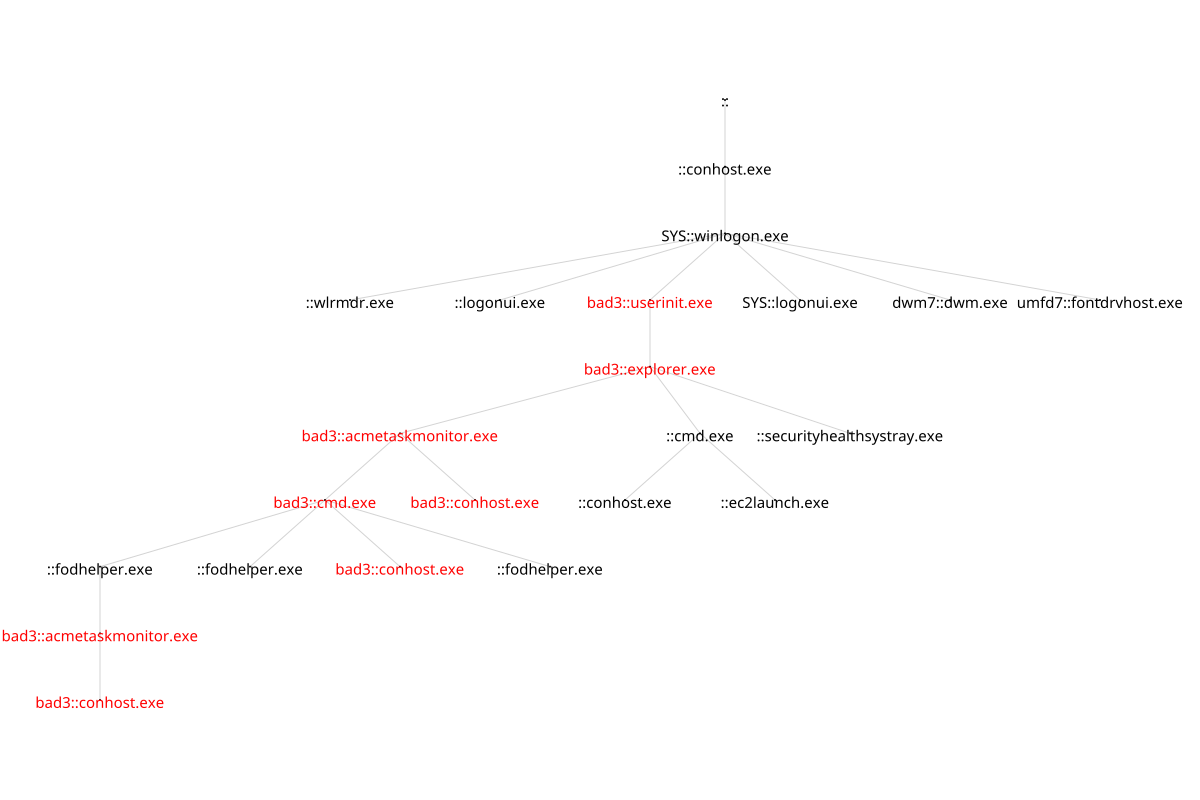

In [20]:
## plot a small one
g = Trees.subgraph(2014)
ly = g.layout_reingold_tilford()
ig.plot(g, bbox=(1200,800), margin=100, layout=ly, vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)


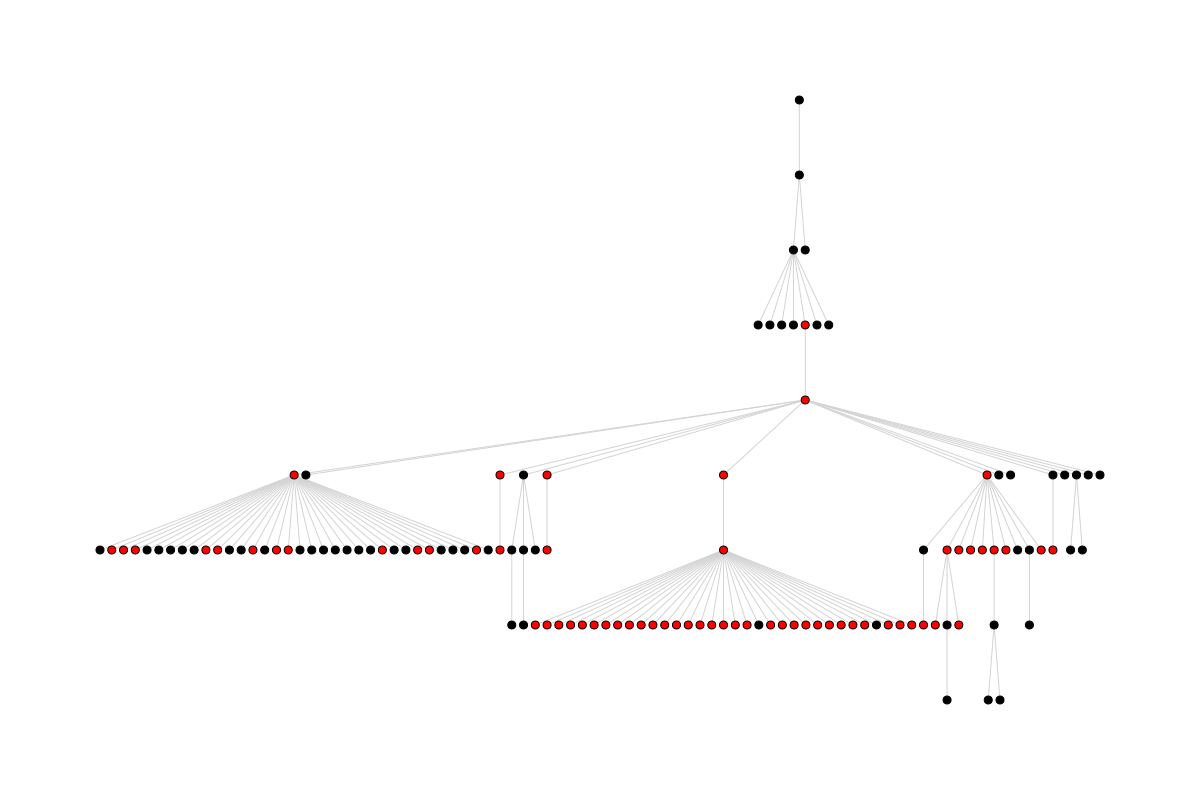

In [21]:
## plot a larger one
g = Trees.subgraph(14973)
ly = g.layout_reingold_tilford()
ig.plot(g, bbox=(1200,800), margin=100, layout=ly, vertex_label_size=0, vertex_size=8, edge_color='lightgrey', edge_arrow_size=0)


# Part II - Build ```process_df``` DataFrame with subtrees and statistics

* 99.98% of components are of size 2 (1,111,052 / 1,111,278) ...
* 210 process trees contain between 3 and 10k nodes
* 16 have more then 10k nodes

For process tree of size [3,10k], we build every subtree of size 3 or more where root has a process name and for each, we save:
* the tree and root node indices
* the number of nodes, layers, leaves and the distribution of nodes across layers
* the number of splits (parent with 2+ children)
* the results are saved in ```process_df```


### Process tree sizes

In [22]:
## size of the Trees
print('number of PIDs:',len(Trees.membership),'number of components:',len(set(Trees.membership)))
Counter([len(x) for x in Trees]).most_common(15)


number of PIDs: 2884171 number of components: 1111278


[(2, 1111052),
 (3, 94),
 (4, 21),
 (5, 12),
 (12, 11),
 (6, 8),
 (7, 4),
 (13, 4),
 (119, 2),
 (10, 2),
 (20, 2),
 (24610, 1),
 (33070, 1),
 (28780, 1),
 (26599, 1)]

In [23]:
## huge components
sum(np.array([len(x) for x in Trees])>10000)

np.int64(16)

### Main function - build ```process_df``` DataFrame

This takes a few minutes.


In [24]:
%%time
## Trees of size 3+ and up to 10000 ; there are only 210 of those
tree_ids = np.where( (np.array([len(x) for x in Trees])>2) & (np.array([len(x) for x in Trees])<=10000) )[0]

## for those, gather detailed layer statistics
L = []
for i in range(len(tree_ids)):
    g = Trees.subgraph(tree_ids[i])
    if int(sum(np.array(g.degree(mode='in'))==0))==1:
        for v in g.vs:
            if v['process'] != '':
                V, l, p = g.bfs(v.index )
                nodes = len(V)
                splits = sum([x>1 for x in list(Counter(np.array(p)[np.array(p)>=0]).values())])
                leaves = nodes - len(set(np.array(p)[np.array(p)>=0]))
                layers = len(l)-1
                b = len([x for x in g.vs[V]['username'] if x is not None and 'baduser' in x])
                #proc = Counter(g.vs[V]['process'])
                _d = dict()
                for j in range(len(l)-1):
                    _d[j] = Counter(g.vs[V[l[j]:l[j+1]]]['process'])
                x = [tree_ids[i],v.index,v['process'], nodes, layers, np.diff(l), splits, leaves, b, _d]
                L.append(x)
    else:
        print('not a tree:',tree_ids[i])

process_df = pd.DataFrame(L, columns=['tree','root','process', 'nodes', 'layers', 'distribution','splits','leaves','badusers','process_dict'])
## keep trees with 3+ nodes
process_df = process_df[process_df.nodes>2]
process_df['count'] = 1
process_df['split_ratio_nodes'] = process_df['splits'] / process_df['nodes']
process_df['has_bad'] = [int(x>0) for x in process_df['badusers']]
process_df.reset_index(drop=True, inplace=True)
process_df.head()


CPU times: user 2min 16s, sys: 622 ms, total: 2min 17s
Wall time: 2min 17s


,tree,root,process,nodes,layers,distribution,splits,leaves,badusers,process_dict,count,split_ratio_nodes,has_bad
0,7,0,unknown,9458,6,"[1, 8881, 317, 106, 147, 6]",87,9235,0,"{0: {'unknown': 1}, 1: {'wmic.exe': 7670, 'ssm...",1,0.009199,0
1,7,34,ssm-document-worker.exe,7,2,"[1, 6]",1,6,0,"{0: {'ssm-document-worker.exe': 1}, 1: {'power...",1,0.142857,0
2,7,40,ngentask.exe,4,2,"[1, 3]",1,3,0,"{0: {'ngentask.exe': 1}, 1: {'ngen.exe': 2, 'c...",1,0.250000,0
3,7,42,compattelrunner.exe,5,2,"[1, 4]",1,4,0,"{0: {'compattelrunner.exe': 1}, 1: {'compattel...",1,0.200000,0
4,7,60,ssm-document-worker.exe,12,2,"[1, 11]",1,11,0,"{0: {'ssm-document-worker.exe': 1}, 1: {'power...",1,0.083333,0


### common process and layer size distribution

The most common ones are very shallow, which is to be expected.


In [25]:
Counter([str(i)+str(j) for i,j in zip (process_df.process,process_df.distribution)]).most_common(20)


[('git.exe[1 2]', 353),
 ('ngentask.exe[1 3]', 284),
 ('bash.exe[1 1 1]', 170),
 ('bash.exe[1 2 2 1]', 134),
 ('taskhostw.exe[1 2 6]', 130),
 ('bash.exe[1 2 1]', 129),
 ('cmd.exe[1 2]', 111),
 ('compattelrunner.exe[1 4]', 80),
 ('compattelrunner.exe[1 2]', 69),
 ('ssm-document-worker.exe[ 1 11]', 47),
 ('winlogon.exe[1 3]', 46),
 ('cmd.exe[1 2 1]', 43),
 ('smss.exe[1 2 3]', 41),
 ('bash.exe[1 1 1 1]', 29),
 ('aws.exe[1 1 1]', 22),
 ('cmd.exe[1 1 1 1]', 17),
 ('cmd.exe[1 1 1]', 17),
 ('downloadfroms3.exe[1 1 1]', 16),
 ('microsoftedgeupdate.exe[1 2 1 4 3]', 14),
 ('setup.exe[1 4 3]', 14)]

### root process distribution (most common ones)


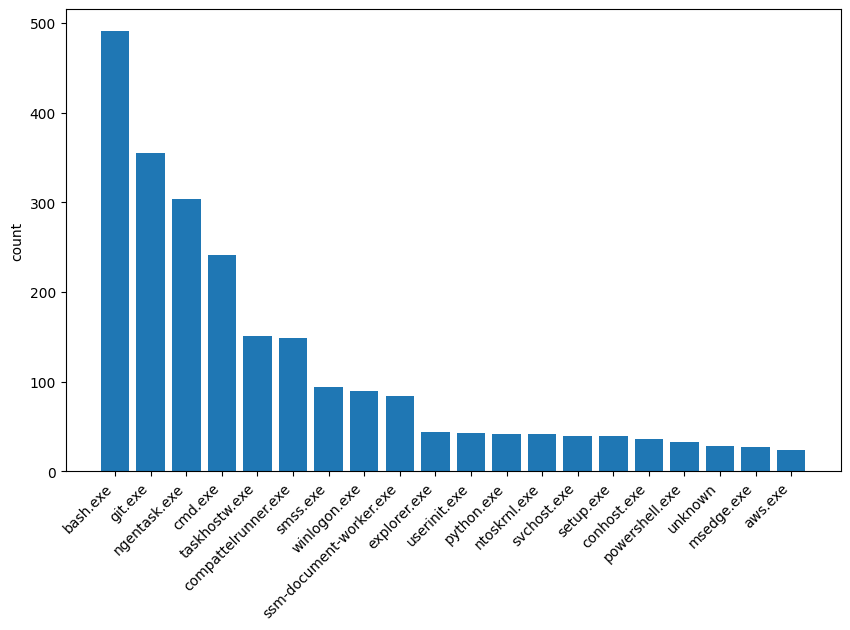

In [26]:
_ctr = Counter(process_df.process)
X = np.array(list(_ctr.keys()))
Y = np.array(list(_ctr.values()))
top = np.argsort(Y)[::-1][:20]
plt.figure(figsize=(10,6))
plt.bar(X[top], Y[top])
#plt.xlabel('process')
plt.ylabel('count')
plt.xticks(rotation=45, ha='right') 
plt.show()

## root process distribution with baduser(s) -- most common ones


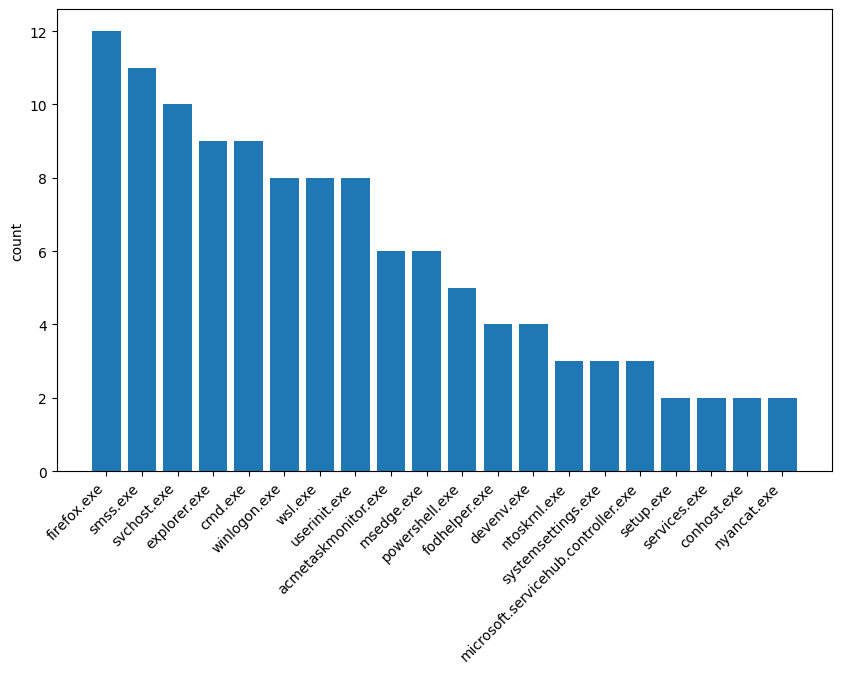

In [27]:
_ctr = Counter(process_df[process_df.has_bad>0].process)
X = np.array(list(_ctr.keys()))
Y = np.array(list(_ctr.values()))
top = np.argsort(Y)[::-1][:20]
plt.figure(figsize=(10,6))
plt.bar(X[top], Y[top])
#plt.xlabel('process')
plt.ylabel('count')
plt.xticks(rotation=45, ha='right') 
plt.show()

### Deep sub-trees

In [28]:
process_df[process_df['layers']>10]

,tree,root,process,nodes,layers,distribution,splits,leaves,badusers,process_dict,count,split_ratio_nodes,has_bad
723,722,5,winlogon.exe,159,12,"[1, 8, 1, 9, 92, 5, 4, 3, 27, 5, 3, 1]",9,133,0,"{0: {'winlogon.exe': 1}, 1: {'dwm.exe': 1, 'lo...",1,0.056604,0
746,722,405,smss.exe,1978,14,"[1, 10, 15, 32, 207, 424, 1208, 38, 4, 3, 27, ...",46,1858,40,"{0: {'smss.exe': 1}, 1: {'smss.exe': 9, 'autoc...",1,0.023256,1
758,722,523,smss.exe,161,13,"[1, 2, 8, 1, 9, 92, 5, 4, 3, 27, 5, 3, 1]",10,134,0,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.062112,0
761,722,1075,userinit.exe,151,11,"[1, 1, 9, 92, 5, 4, 3, 27, 5, 3, 1]",8,126,0,"{0: {'userinit.exe': 1}, 1: {'explorer.exe': 1...",1,0.052980,0
771,722,1563,ntoskrnl.exe,2926,15,"[1, 4, 953, 16, 32, 207, 424, 1208, 38, 4, 3, ...",48,2803,40,"{0: {'ntoskrnl.exe': 1}, 1: {'unknown': 1, 'sm...",1,0.016405,1
785,724,4,smss.exe,201,11,"[1, 2, 6, 1, 10, 166, 3, 4, 1, 3, 4]",12,186,119,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.059701,1
788,724,10,smss.exe,848,12,"[1, 13, 18, 50, 8, 59, 606, 35, 25, 13, 14, 6]",63,713,360,"{0: {'smss.exe': 1}, 1: {'smss.exe': 12, 'auto...",1,0.074292,1
864,724,359,smss.exe,281,11,"[1, 2, 6, 1, 13, 241, 6, 6, 1, 2, 2]",14,261,155,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.049822,1
878,724,468,ntoskrnl.exe,852,13,"[1, 4, 13, 18, 50, 8, 59, 606, 35, 25, 13, 14, 6]",64,716,360,"{0: {'ntoskrnl.exe': 1}, 1: {'smss.exe': 1, 'u...",1,0.075117,1
1747,733,345,smss.exe,1336,11,"[1, 14, 27, 51, 193, 409, 434, 149, 42, 14, 2]",80,1133,296,"{0: {'smss.exe': 1}, 1: {'smss.exe': 14}, 2: {...",1,0.059880,1


### Filtering

From the ```process_df``` table, we can filter sub-trees in various ways (size, proportion of splits, etc...). We show a few examples below.


In [29]:
## utility function -- getting a subtree from Trees object
def get_subtree(Trees, tree_id, root_id):
    nodes, _ ,_ = Trees.subgraph(tree_id).bfs(root_id)
    g = Trees.subgraph(tree_id).subgraph(nodes)
    g["ly"] = g.layout_reingold_tilford() ## save a layout for plotting
    return g

### Example: small subtrees with large number of splits

We also visualize a few. Node labels are: ```short_username::process_name```


In [30]:
## extract
_df = process_df[ (process_df['nodes']>=10) & (process_df['nodes']<=20) & (process_df.split_ratio_nodes>.3) ]
_df

,tree,root,process,nodes,layers,distribution,splits,leaves,badusers,process_dict,count,split_ratio_nodes,has_bad
797,724,34,nyancat.exe,18,7,"[1, 2, 3, 4, 1, 3, 4]",6,11,9,"{0: {'nyancat.exe': 1}, 1: {'conhost.exe': 1, ...",1,0.333333,1
798,724,36,acmetaskmonitor.exe,16,6,"[1, 3, 4, 1, 3, 4]",5,10,7,"{0: {'acmetaskmonitor.exe': 1}, 1: {'fodhelper...",1,0.312500,1
830,724,184,acmetaskmonitor.exe,15,6,"[1, 3, 6, 1, 2, 2]",5,9,4,"{0: {'acmetaskmonitor.exe': 1}, 1: {'cmd.exe':...",1,0.333333,1
849,724,251,cmd.exe,13,5,"[1, 4, 1, 3, 4]",4,8,5,"{0: {'cmd.exe': 1}, 1: {'fodhelper.exe': 3, 'c...",1,0.307692,1
880,724,573,nyancat.exe,17,7,"[1, 2, 3, 6, 1, 2, 2]",6,10,6,"{0: {'nyancat.exe': 1}, 1: {'acmetaskmonitor.e...",1,0.352941,1
1680,731,132,smss.exe,16,6,"[1, 2, 5, 1, 3, 4]",5,10,0,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.312500,0
2423,14156,40,smss.exe,16,6,"[1, 2, 5, 1, 3, 4]",5,10,0,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.312500,0
2491,26424,180,smss.exe,12,6,"[1, 2, 4, 1, 2, 2]",4,7,0,"{0: {'smss.exe': 1}, 1: {'winlogon.exe': 1, 'c...",1,0.333333,0


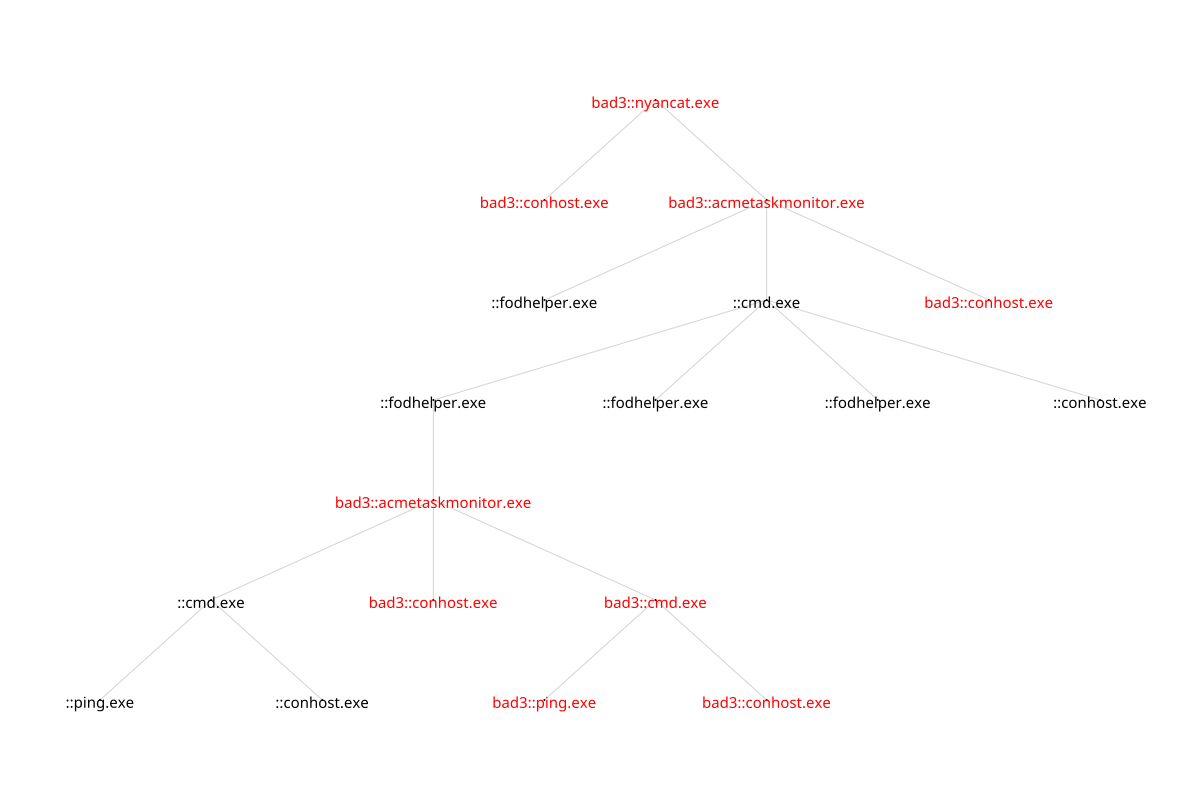

In [31]:
## visualize
sg = get_subtree(Trees, 724, 34)
ig.plot(sg, bbox=(1200,800), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)


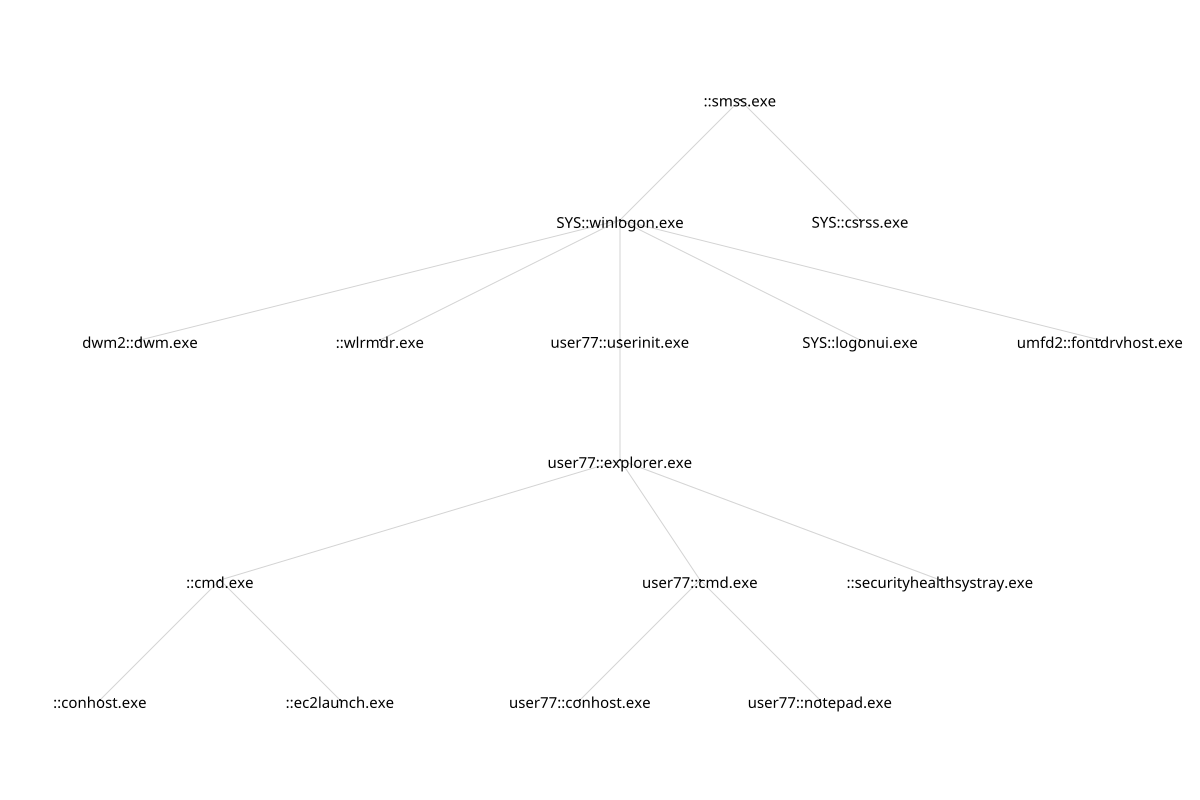

In [32]:
## visualize
sg = get_subtree(Trees, 731, 132)
ig.plot(sg, bbox=(1200,800), margin=100, layout=sg['ly'], vertex_label_size=15, vertex_size=1, edge_color='lightgrey', edge_arrow_size=0)
